In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import random
import tensorflow as tf
from sklearn import preprocessing, neighbors, naive_bayes, tree, ensemble, svm, neural_network, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

In [2]:
df = pd.read_csv('voice.csv')
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


### Visualization

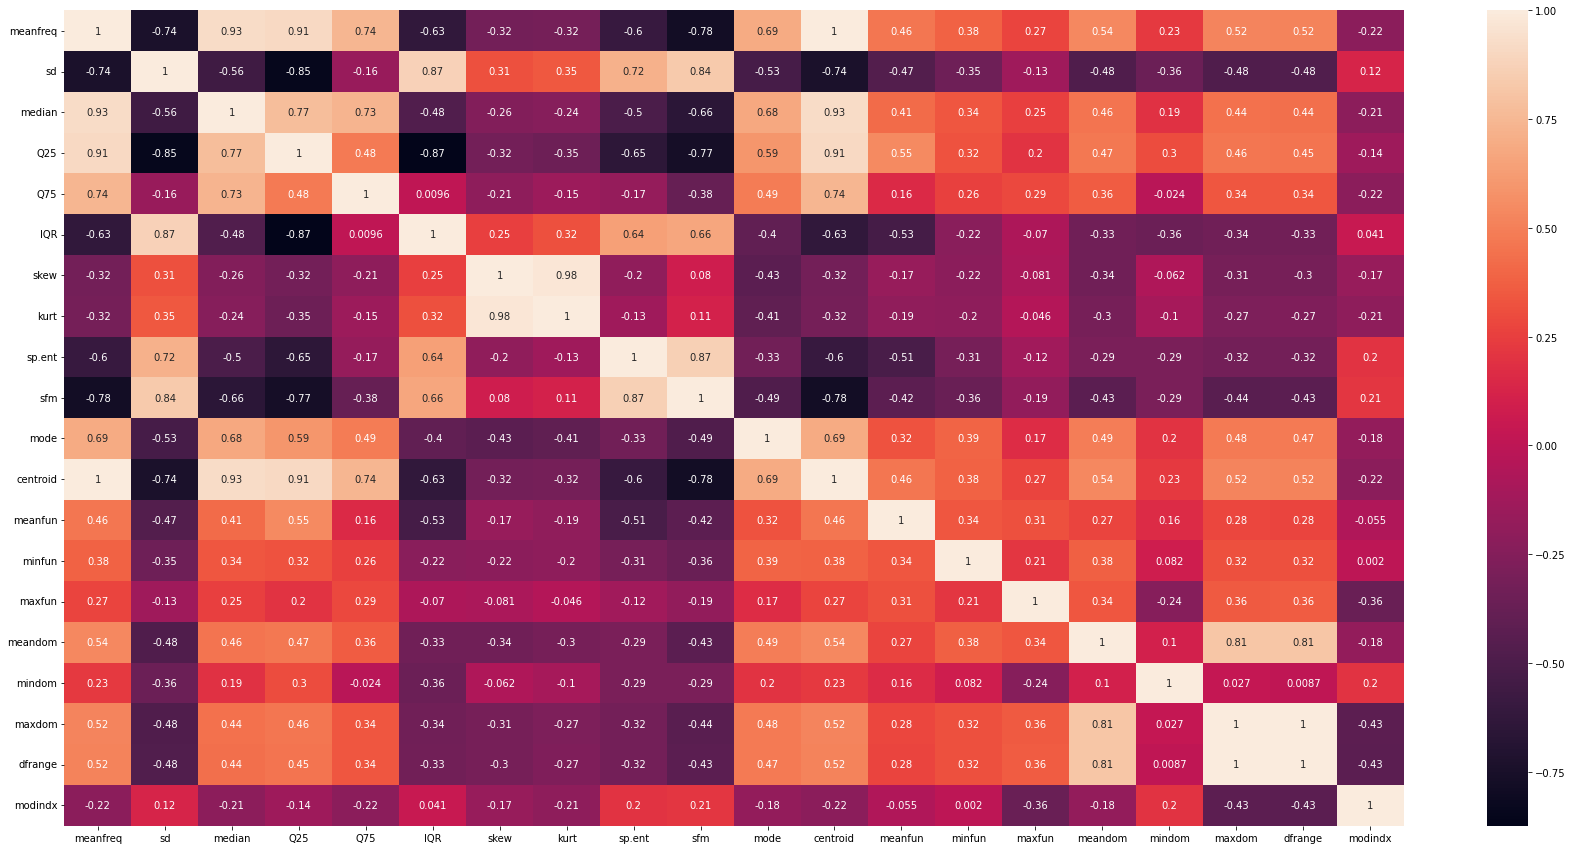

In [3]:
correlation = df.corr()

fig=plt.gcf()
fig.set_size_inches(30,15)
sns.heatmap(data=correlation, annot=True)
plt.show()

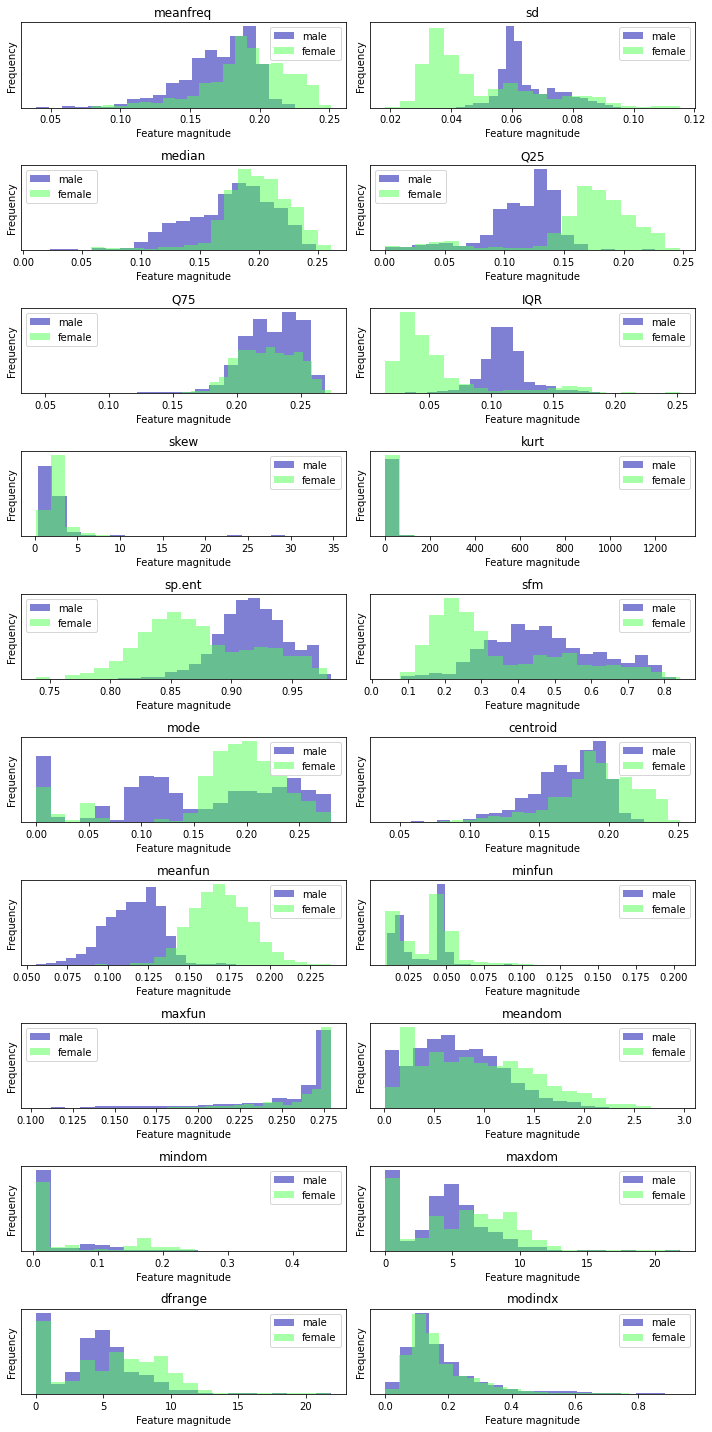

In [4]:
male = df.loc[df['label']=='male']
female = df.loc[df['label']=='female']
fig, axes = plt.subplots(10, 2, figsize=(10,20))
ax = axes.ravel()
for i in range(20):
    ax[i].hist(male.iloc[:,i], bins=20, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(female.iloc[:, i], bins=20, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(list(male)[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["male", "female"], loc="best")

fig.tight_layout()

### Best features

In [5]:
def select_kbest_clf(data_frame, target, k=5):
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [6]:
k = select_kbest_clf(df, 'label', k=5).sort_values(['F Score'],ascending=False)
k

,F Score,P Value,Support,Attribute
12,7228.790362,0.000000e+00,True,meanfun
5,1965.750000,0.000000e+00,True,IQR
3,1121.569224,9.140832e-211,True,Q25
8,1003.308717,1.614016e-191,True,sp.ent
1,945.461376,6.654756e-182,True,sd
9,463.923194,3.877715e-96,False,sfm
0,406.752820,3.368951e-85,False,meanfreq
11,406.752820,3.368951e-85,False,centroid
2,277.588158,8.259210e-60,False,median
17,126.024161,1.050986e-28,False,maxdom


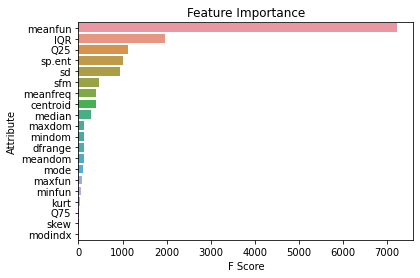

In [7]:
k1=sns.barplot(x=k['F Score'],y=k['Attribute'])
k1.set_title('Feature Importance')
plt.show()

In [8]:
best_features = k['Attribute'].iloc[:10].values

### Data preparation

In [9]:
target_names = ['female', 'male']
df.label.value_counts()

male      1584
female    1584
Name: label, dtype: int64

In [10]:
x_data = df[best_features]
y = df.label.values

In [11]:
x = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))
x.head()

,meanfun,IQR,Q25,sp.ent,sd,sfm,meanfreq,centroid,median,maxdom
0,0.157706,0.254828,0.060063,0.635798,0.473409,0.564526,0.096419,0.096419,0.084125,0.000000
1,0.287642,0.246961,0.077635,0.630964,0.505075,0.591578,0.125828,0.125828,0.116900,0.002144
2,0.236945,0.457148,0.034284,0.442738,0.675536,0.548382,0.179222,0.179222,0.102873,0.000357
3,0.183442,0.407358,0.389906,0.923261,0.554611,0.856457,0.528261,0.528261,0.587559,0.025375
4,0.279190,0.474474,0.317627,0.958736,0.627209,0.926348,0.452195,0.452195,0.454272,0.250536


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

### Logistic regression

In [13]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
log_reg_y_pred=log_reg.predict(x_test)

In [14]:
print(classification_report(y_test, log_reg_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9807    0.9673    0.9739       367
        male     0.9721    0.9835    0.9778       425

    accuracy                         0.9760       792
   macro avg     0.9764    0.9754    0.9759       792
weighted avg     0.9761    0.9760    0.9760       792



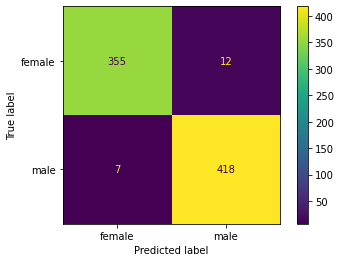

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_y_pred)
plt.show()

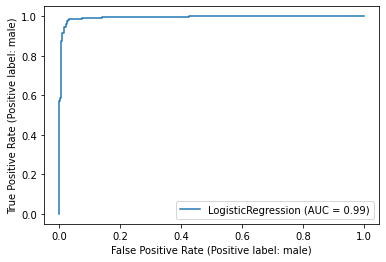

In [16]:
RocCurveDisplay.from_estimator(log_reg, x_test, y_test)
plt.show()

### KNN Classifier

In [17]:
def knn_error(K, x_train, y_train, x_test, y_test):
    error_rate = []
    
    for i in K:
        knn = neighbors.KNeighborsClassifier(n_neighbors = i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    
    return error_rate

Lowest error is 0.012626262626262626 occurs at k=7.


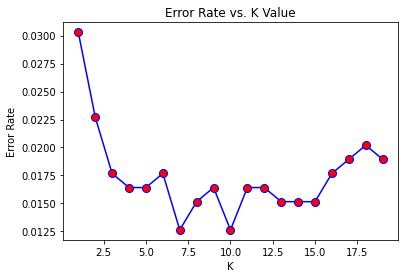

In [18]:
K = range(1, 20)
error_rate = knn_error(K, x_train, y_train, x_test, y_test)
kloc = error_rate.index(min(error_rate))
best_k_value = K[kloc]
print("Lowest error is %s occurs at k=%s." % (error_rate[kloc], K[kloc]))

plt.plot(K, error_rate, color='blue', linestyle='solid', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [19]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors = best_k_value)
knn_model.fit(x_train, y_train)
knn_y_pred = knn_model.predict(x_test)

In [20]:
print(classification_report(y_test, knn_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9811    0.9918    0.9864       367
        male     0.9929    0.9835    0.9882       425

    accuracy                         0.9874       792
   macro avg     0.9870    0.9877    0.9873       792
weighted avg     0.9874    0.9874    0.9874       792



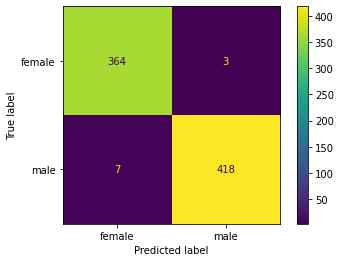

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_y_pred)
plt.show()

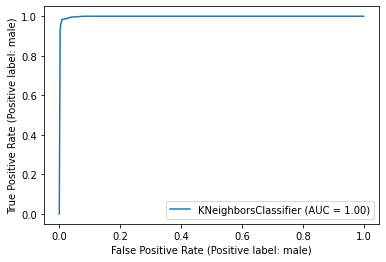

In [22]:
RocCurveDisplay.from_estimator(knn_model, x_test, y_test)
plt.show()

### Naive  Bayes

In [23]:
nb_model = naive_bayes.GaussianNB()
nb_model.fit(x_train, y_train)
nb_y_pred = nb_model.predict(x_test)

In [24]:
print(classification_report(y_test, nb_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9405    0.9046    0.9222       367
        male     0.9203    0.9506    0.9352       425

    accuracy                         0.9293       792
   macro avg     0.9304    0.9276    0.9287       792
weighted avg     0.9297    0.9293    0.9292       792



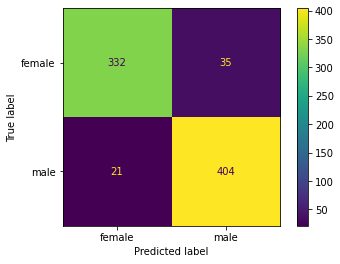

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, nb_y_pred)
plt.show()

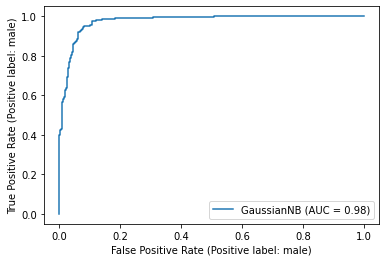

In [26]:
RocCurveDisplay.from_estimator(nb_model, x_test, y_test)
plt.show()

### Decision tree

In [27]:
def dt_error(nodes, x_train, y_train, x_test, y_test):
    error_rate = []
    
    for k in nodes:
        model = tree.DecisionTreeClassifier(max_leaf_nodes=k)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    
    return error_rate

Lowest error is 0.027777777777777776 occurs at n=7.


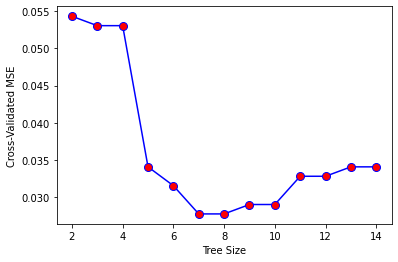

In [28]:
nodes = range(2, 15)
error_rate = dt_error(nodes, x_train, y_train, x_test, y_test)
kloc = error_rate.index(min(error_rate))
best_n_value = nodes[kloc]
print("Lowest error is %s occurs at n=%s." % (error_rate[kloc], nodes[kloc]))

plt.plot(nodes, error_rate, color='blue', linestyle='solid', marker='o', markerfacecolor='red', markersize=8)
plt.xlabel('Tree Size')
plt.ylabel('Cross-Validated MSE')
plt.show()

In [29]:
dt = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = best_n_value)
dt.fit(x_train, y_train)
dt_y_pred = dt.predict(x_test)

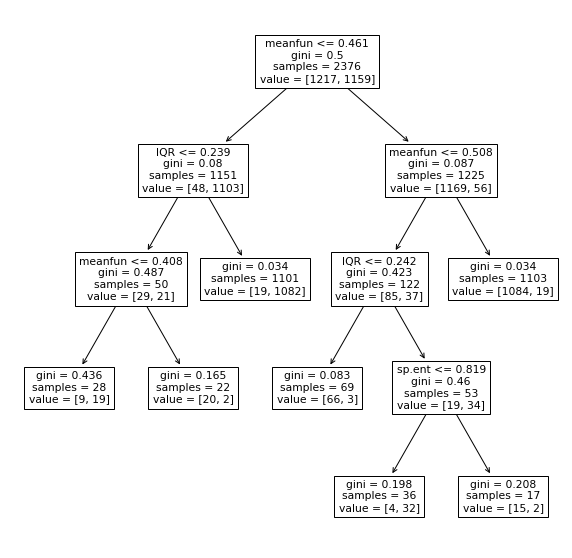

In [30]:
plt.figure(figsize = (10, 10))
tree.plot_tree(dt, feature_names=best_features)
plt.show()

In [31]:
print(classification_report(y_test, dt_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9725    0.9646    0.9685       367
        male     0.9696    0.9765    0.9730       425

    accuracy                         0.9710       792
   macro avg     0.9711    0.9705    0.9708       792
weighted avg     0.9710    0.9710    0.9710       792



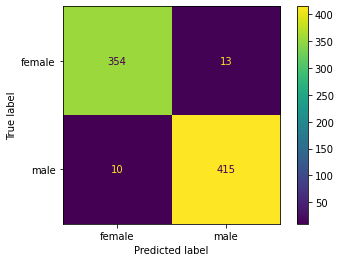

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, dt_y_pred)
plt.show()

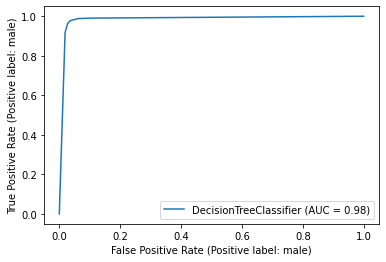

In [33]:
RocCurveDisplay.from_estimator(dt, x_test, y_test)
plt.show()

### Random Forest

In [34]:
def rf_error(e, x_train, y_train, x_test, y_test):
    error_rate = []
    
    for i in e:
        model = ensemble.RandomForestClassifier(n_estimators = i)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    
    return error_rate

Lowest error is 0.020202020202020204 occurs at n=21.


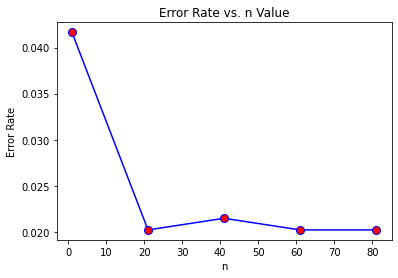

In [35]:
e = range(1, 100, 20)
error_rate = rf_error(e,x_train,y_train,x_test,y_test)
nloc = error_rate.index(min(error_rate))
best_e_value = e[nloc]

print("Lowest error is %s occurs at n=%s." % (error_rate[nloc], e[nloc]))

plt.plot(e, error_rate, color='blue', linestyle='solid', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. n Value')
plt.xlabel('n')
plt.ylabel('Error Rate')
plt.show() 

In [36]:
rf_model = ensemble.RandomForestClassifier(n_estimators = best_e_value)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

In [37]:
print(classification_report(y_test, rf_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9627    0.9837    0.9730       367
        male     0.9856    0.9671    0.9762       425

    accuracy                         0.9747       792
   macro avg     0.9741    0.9754    0.9746       792
weighted avg     0.9750    0.9747    0.9748       792



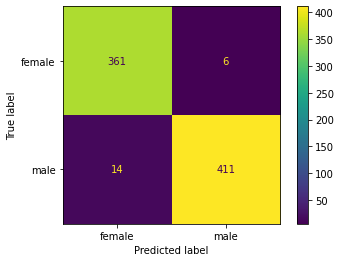

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_y_pred)
plt.show()

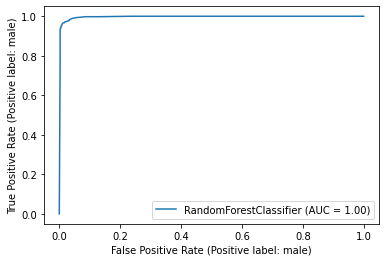

In [39]:
RocCurveDisplay.from_estimator(rf_model, x_test, y_test)
plt.show()

### Support Vector Machine

In [40]:
def svm_kernel(x_train, y_train, x_test, y_test):
    rate=[]
    kernel=['rbf','poly','linear']
    
    for i in kernel:
        model=svm.SVC(kernel=i).fit(x_train,y_train)
        
        y_pred=model.predict(x_train)
        print(i, 'in-sample accuracy in SVM: ', accuracy_score(y_train,y_pred))
        
        y_pred=model.predict(x_test)
        print(i, 'out-of-sample accuracy in SVM: ', accuracy_score(y_test,y_pred))
        
        rate.append(accuracy_score(y_test,y_pred))
        
    nloc = rate.index(max(rate))
    print("Highest accuracy is %s occurs at %s kernel." % (rate[nloc], kernel[nloc]))
    return kernel[nloc]

In [41]:
def svm_error(kernel, C, x_train, y_train, x_test, y_test):
    error_rate = []
    
    for i in C:
        model=svm.SVC(kernel=kernel,C=i).fit(x_train,y_train)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    
    return error_rate

In [42]:
kernel = svm_kernel(x_train, y_train, x_test, y_test)

rbf in-sample accuracy in SVM:  0.9772727272727273
rbf out-of-sample accuracy in SVM:  0.9797979797979798
poly in-sample accuracy in SVM:  0.9806397306397306
poly out-of-sample accuracy in SVM:  0.9810606060606061
linear in-sample accuracy in SVM:  0.9675925925925926
linear out-of-sample accuracy in SVM:  0.976010101010101
Highest accuracy is 0.9810606060606061 occurs at poly kernel.


Lowest error is 0.013888888888888888 occurs at C=6.


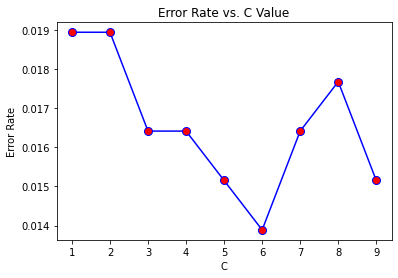

In [43]:
C = range(1, 10)
error_rate = svm_error(kernel, C, x_train, y_train, x_test, y_test)
cloc = error_rate.index(min(error_rate))
bets_c_value = C[cloc]

print("Lowest error is %s occurs at C=%s." % (error_rate[cloc], C[cloc]))
plt.plot(C, error_rate, color='blue', linestyle='solid', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. C Value')
plt.xlabel('C')
plt.ylabel('Error Rate')
plt.show()

In [44]:
svm_model = svm.SVC(kernel = kernel, C = bets_c_value)
svm_model.fit(x_train, y_train)
svm_y_pred = svm_model.predict(x_test)

In [45]:
print(classification_report(y_test, svm_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9863    0.9837    0.9850       367
        male     0.9859    0.9882    0.9871       425

    accuracy                         0.9861       792
   macro avg     0.9861    0.9859    0.9860       792
weighted avg     0.9861    0.9861    0.9861       792



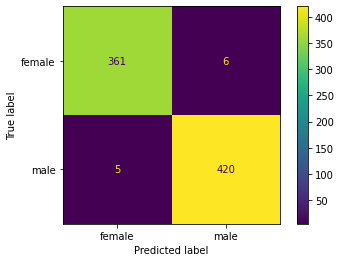

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, svm_y_pred)
plt.show()

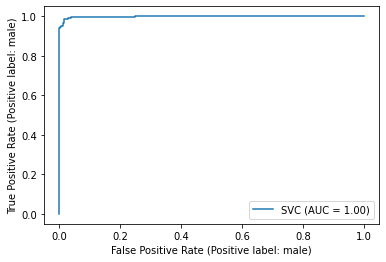

In [47]:
RocCurveDisplay.from_estimator(svm_model, x_test, y_test)
plt.show()

### Neural network

In [48]:
def nn_error(hidden_layers, x_train, y_train, x_test, y_test):
    error_rate = []
    
    for i in hidden_layers:
        model = neural_network.MLPClassifier(solver='adam', alpha=1e-5,
                                       hidden_layer_sizes=i,
                                       activation='logistic',random_state=17,
                                       max_iter=2000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error_rate.append(np.mean(y_pred != y_test))
    
    return error_rate

Lowest error is 0.022727272727272728 occurs at C=7.


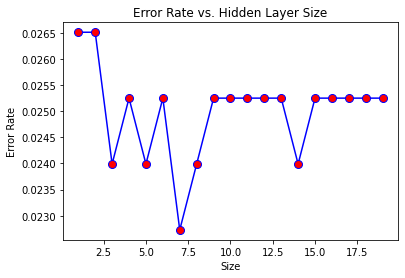

In [49]:
hidden_layers = range(1, 20)
error_rate = nn_error(hidden_layers, x_train, y_train, x_test, y_test)
kloc = error_rate.index(min(error_rate))
best_layers_value = hidden_layers[kloc]
print("Lowest error is %s occurs at C=%s." % (error_rate[kloc], hidden_layers[kloc]))

plt.plot(hidden_layers, error_rate, color='blue', linestyle='solid', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. Hidden Layer Size')
plt.xlabel('Size')
plt.ylabel('Error Rate')
plt.show()

In [50]:
nn_model = neural_network.MLPClassifier(solver='adam', alpha=1e-5,
                                       hidden_layer_sizes=best_layers_value,
                                       activation='logistic',random_state=17,
                                       max_iter=2000)
nn_model.fit(x_train, y_train)
nn_y_pred = nn_model.predict(x_test)

In [51]:
print(classification_report(y_test, nn_y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      female     0.9755    0.9755    0.9755       367
        male     0.9788    0.9788    0.9788       425

    accuracy                         0.9773       792
   macro avg     0.9772    0.9772    0.9772       792
weighted avg     0.9773    0.9773    0.9773       792



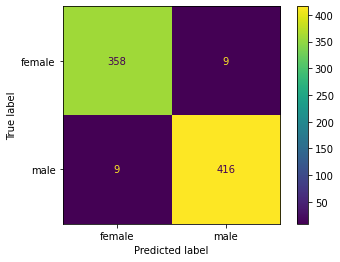

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, nn_y_pred)
plt.show()

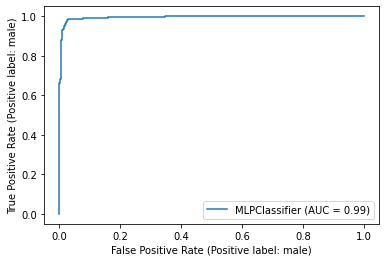

In [53]:
RocCurveDisplay.from_estimator(nn_model, x_test, y_test)
plt.show()

In [2]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [5]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
print(sig.shape)
Audio(data=sig, rate=sr)

formats: can't open input file `file.wav': No such file or directory


RuntimeError: Error loading audio file: failed to open file file.wav

### Comparisons

In [98]:
models = {
    "Logistic Regresion": log_reg, 
    "KNN": knn_model, 
    "Naive Bayes": nb_model,
    "Decision tree": dt,
    "Random forest": rf_model,
    "SVM": svm_model, 
    "Neural network": nn_model
}

df = pd.DataFrame(columns=["Model", "Accuracy"])
df["Model"] = [name for name, _ in models.items()]
df["Accuracy"] = [accuracy_score(model.predict(x_test), y_test) for _, model in models.items()]
df = df.sort_values(by='Accuracy', ascending=False)
df

,Model,Accuracy
1,KNN,0.987374
5,SVM,0.986111
6,Neural network,0.977273
0,Logistic Regresion,0.976010
4,Random forest,0.974747
3,Decision tree,0.970960
2,Naive Bayes,0.929293


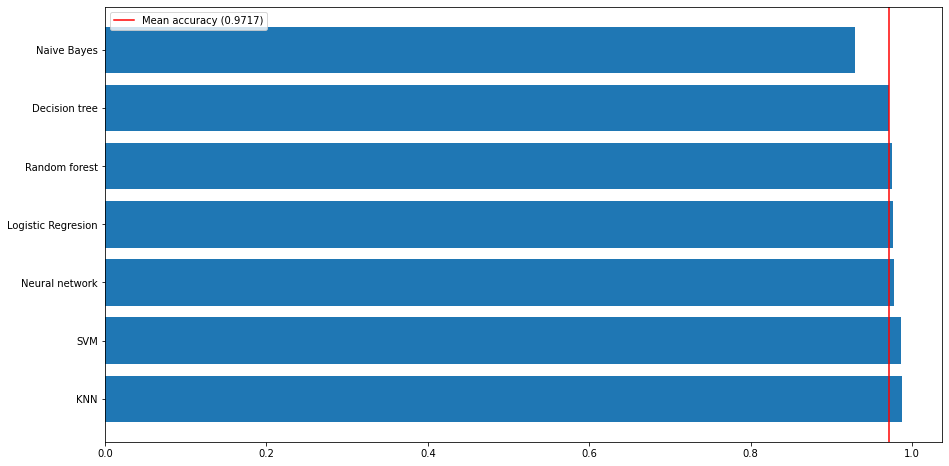

In [99]:
plt.figure(figsize=(15, 8))
avg_accuracy = df['Accuracy'].mean()
plt.barh(df['Model'], df['Accuracy'])
plt.axvline(x = avg_accuracy, color='r', label='Mean accuracy (' + str(round(avg_accuracy, 4)) + ')')
plt.legend(loc = 2)
plt.show()

<Figure size 1080x864 with 0 Axes>

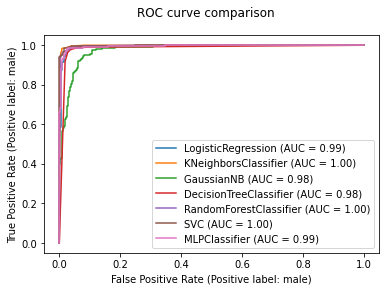

In [61]:
plt.figure(figsize=(15,12))

fig1 = RocCurveDisplay.from_estimator(log_reg, x_test, y_test)
fig1.figure_.suptitle("ROC curve comparison")

RocCurveDisplay.from_estimator(knn_model, x_test, y_test, ax=fig1.ax_)
RocCurveDisplay.from_estimator(nb_model, x_test, y_test, ax=fig1.ax_)
RocCurveDisplay.from_estimator(dt, x_test, y_test, ax=fig1.ax_)
RocCurveDisplay.from_estimator(rf_model, x_test, y_test, ax=fig1.ax_)
RocCurveDisplay.from_estimator(svm_model, x_test, y_test, ax=fig1.ax_)
RocCurveDisplay.from_estimator(nn_model, x_test, y_test, ax=fig1.ax_)

plt.legend(loc=0)
plt.show()